<a href="https://colab.research.google.com/github/jlyu55/Imbalanced_Classification/blob/main/llama3_8b_instruct_act_prob_TruthfulQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probing Llama-3-8B-Instruct activations on TruthfulQA

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Extract activation

In [ ]:
import os
import sys
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

from utils import LR_logit_experiment2

from google.colab import userdata  # Extract Colab Secrets (tokens)
from huggingface_hub import login

# HuggingFace Access
HF_TOKEN = userdata.get('HF_TOKEN')
assert HF_TOKEN, "HF_TOKEN NOT FOUND!"
login(token=HF_TOKEN)  # login to HuggingFace

In [ ]:
# Use baukit's TraceDict to register forward hooks and capture per-layer and/or
# per-head activations without modifying the model.
try:
    from baukit import TraceDict
except ModuleNotFoundError:
    import sys, subprocess
    cmd = [
        sys.executable, "-m", "pip", "install",
        "-qq", "--disable-pip-version-check",
        "git+https://github.com/davidbau/baukit",
    ]
    subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    from baukit import TraceDict

from utils_llama import *

### Meta-Llama-3-8B-Instruct

https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map="auto"
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

### TruthfulQA Dataset

https://huggingface.co/datasets/domenicrosati/TruthfulQA

In [ ]:
# Load TruthfulQA dataset from Hugging Face
dataset = load_dataset("truthfulqa/truthful_qa", 'generation')['validation']
print(dataset)

prompts, labels, categories = tokenized_tqa_gen(dataset, tokenizer)
res = get_llama_activations_last_token(model, prompts[0], device)

Dataset({
    features: ['type', 'category', 'question', 'best_answer', 'correct_answers', 'incorrect_answers', 'source'],
    num_rows: 817
})


In [ ]:
all_activations = []
for prompt in tqdm(prompts):
    activations = get_llama_activations_last_token(model, prompt, device)
    all_activations.append(activations.copy())
all_activations_arr = np.stack(all_activations, axis=0)
print(all_activations_arr.shape)

100%|██████████| 5918/5918 [05:03<00:00, 19.52it/s]


(5918, 32, 32, 128)


In [ ]:
np.save('../data/Llama-3-8B-Instruct/act.npy', all_activations_arr)
np.save('../data/Llama-3-8B-Instruct/label.npy', np.array(labels))
np.save('../data/Llama-3-8B-Instruct/category.npy', np.array(categories))

## Probing for activation


In [ ]:
%%capture
!apt-get update
!apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super ghostscript

In [ ]:
DATA_DIR = '../data/Llama-3-8B-Instruct'
X = np.load(os.path.join(DATA_DIR, "act.npy"))
y = np.load(os.path.join(DATA_DIR, "label.npy"))

print(X.shape)
print(y.shape)
print(Counter(y))

(5918, 32, 32, 128)
(5918,)
Counter({np.int64(0): 3318, np.int64(1): 2600})


Imbalanced training Set: {np.int64(0): 663, np.int64(1): 27}
pi = 0.039
n = 690


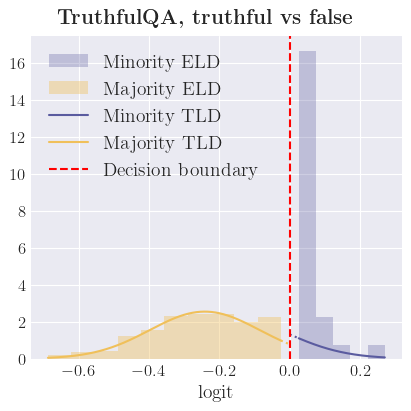

In [ ]:
logit_arr, y_list = LR_logit_experiment2(
    X[:, 30, 25, :], y,
    save_dir='',
    pai=0.04, test_size=0.8, random_state=42, classes=(0, 1),
    whitening_rank=0, overlay_fitted_test_Gaussian=True,
    title='\\textbf{TruthfulQA, truthful vs false}',
    save=True, fig_size=(4, 4),
    binwidth0=1, binwidth1=1, bins0=10, bins1=5,
    legend=True, title_font=15, text_font=12,
)
logit1, logit2 = logit_arr
y_imb, y_test = y_list

In [ ]:
def plot_scatter_with_marginals_hist(
    x1, x2, y,
    labels=('Minority','Majority'),
    colors=('#5A5B9F', '#F0C05A'),
    figsize=(6, 6),
    q_low=1, q_high=99,
    alpha1=0.3, alpha0=0.4,
    density=True,
    xlabel='1st direction logit (max-margin)',
    ylabel='2nd direction logit (orthogonal)',
    title='',
    xlim=None, ylim=None,
    bins_x_minor=10, bins_y_minor=10,
    bins_x_major=20, bins_y_major=20,
    point_size=18,
    edgecolor='none',
    rasterized=True,
    title_font=20, text_font=16,
    save=False, path=''
):
    x1 = np.asarray(x1).ravel()
    x2 = np.asarray(x2).ravel()
    y  = np.asarray(y).ravel()
    assert x1.shape == x2.shape == y.shape

    m1 = (y == 1)
    m0 = ~m1
    x1_1, x2_1 = x1[m1], x2[m1]
    x1_0, x2_0 = x1[m0], x2[m0]

    if xlim is not None:
        xmin, xmax = float(xlim[0]), float(xlim[1])
    else:
        xmin, xmax = np.percentile(x1, [q_low, q_high]); xr = xmax - xmin or 1.0
        xmin, xmax = xmin - 0.05*xr, xmax + 0.05*xr

    if ylim is not None:
        ymin, ymax = float(ylim[0]), float(ylim[1])
    else:
        ymin, ymax = np.percentile(x2, [q_low, q_high]); yr = ymax - ymin or 1.0
        ymin, ymax = ymin - 0.05*yr, ymax + 0.05*yr

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    with plt.style.context('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle'):
        fig = plt.figure(figsize=figsize, constrained_layout=True)
        fig.suptitle(title, fontweight='bold', fontsize=title_font)
        gs  = GridSpec(2, 2, figure=fig, height_ratios=[1,4], width_ratios=[4,1],
                       hspace=0.02, wspace=0.02)
        ax_top   = fig.add_subplot(gs[0,0])
        ax_main  = fig.add_subplot(gs[1,0])
        ax_right = fig.add_subplot(gs[1,1])

        # Main: Scatter plot
        if x1_1.size:
            ax_main.scatter(
                x1_1, x2_1, s=point_size, alpha=alpha1,
                facecolor=colors[0], edgecolor=edgecolor, rasterized=rasterized
            )
        if x1_0.size:
            ax_main.scatter(
                x1_0, x2_0, s=point_size, alpha=alpha0,
                facecolor=colors[1], edgecolor=edgecolor, rasterized=rasterized
            )

        # Above: Histogram
        if x1_1.size:
            ax_top.hist(x1_1, bins=bins_x_minor, density=density, color=colors[0], alpha=alpha1)
        if x1_0.size:
            ax_top.hist(x1_0, bins=bins_x_major, density=density, color=colors[1], alpha=alpha0)

        # Right: Histogram
        if x2_1.size:
            ax_right.hist(x2_1, bins=bins_y_minor, density=density, color=colors[0],
                        alpha=alpha1, orientation='horizontal')
        if x2_0.size:
            ax_right.hist(x2_0, bins=bins_y_major, density=density, color=colors[1],
                        alpha=alpha0, orientation='horizontal')

        for s in ['left', 'right', 'top']:
            ax_top.spines[s].set_visible(False)
        ax_top.spines['bottom'].set_visible(True)
        ax_top.spines['bottom'].set_linewidth(0.8)

        for s in ['top', 'right', 'bottom']:
            ax_right.spines[s].set_visible(False)
        ax_right.spines['left'].set_visible(True)
        ax_right.spines['left'].set_linewidth(0.8)

        ax_main.set_xlim(xmin, xmax); ax_main.set_ylim(ymin, ymax)
        ax_top.set_xlim(xmin, xmax);  ax_right.set_ylim(ymin, ymax)
        ax_top.tick_params(labelbottom=False);  ax_top.set_yticks([])
        ax_right.tick_params(labelleft=False);  ax_right.set_xticks([])
        ax_main.tick_params(axis='x', labelsize=text_font)
        ax_main.tick_params(axis='y', labelsize=text_font)
        ax_main.set_xlabel(xlabel, fontsize=text_font+2)
        ax_main.set_ylabel(ylabel, fontsize=text_font+2)

        handles = [
            Line2D([0],[0], color=colors[0], lw=6, alpha=max(alpha1, 0.6)),
            Line2D([0],[0], color=colors[1], lw=6, alpha=max(alpha0, 0.6))
        ]
        ax_main.legend(handles, labels, loc="best", fontsize=text_font+2)

    if save:
        plt.savefig(path)
    else:
        plt.show()

    return fig, (ax_main, ax_top, ax_right)


def stratified_subsample_binary(y, p=0.2, seed=None):
    assert set(np.unique(y)).issubset({0, 1})
    N = y.shape[0]
    # At least one sameple
    test_size = max(p, 1.0 / N)

    _, idx = train_test_split(np.arange(N), test_size=test_size,
                              random_state=seed, stratify=y)
    return np.sort(idx)

(<Figure size 600x600 with 3 Axes>,
 (<Axes: xlabel='1st direction logit (max-margin)', ylabel='2nd direction logit (orthogonal)'>,
  <Axes: >,
  <Axes: >))

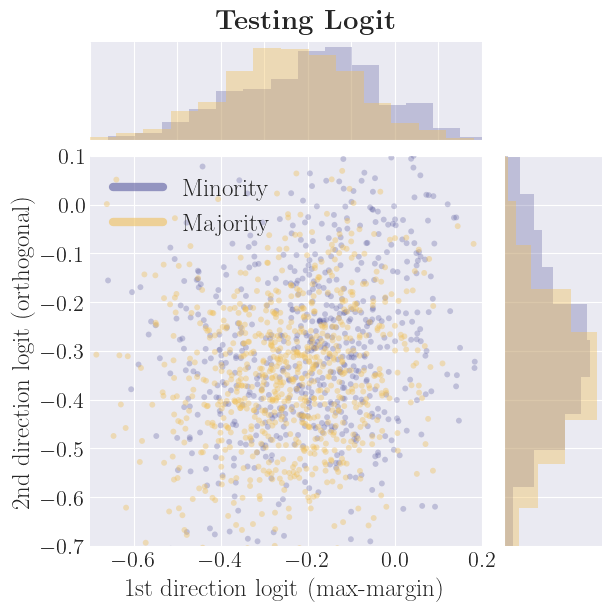

In [ ]:
idx = stratified_subsample_binary(y_test, p=0.3, seed=42)
plot_scatter_with_marginals_hist(
    logit1[1][idx], logit2[1][idx], y_test[idx],
    bins_x_minor=15, bins_y_minor=15,
    bins_x_major=15, bins_y_major=15,
    xlim=(-0.7, 0.2), ylim=(-0.7, 0.1),
    title='\\textbf{Testing Logit}',
    save=True,
    path='llama3-8B_act_2Dtest.pdf'
)

(<Figure size 600x600 with 3 Axes>,
 (<Axes: xlabel='1st direction logit (max-margin)', ylabel='2nd direction logit (orthogonal)'>,
  <Axes: >,
  <Axes: >))

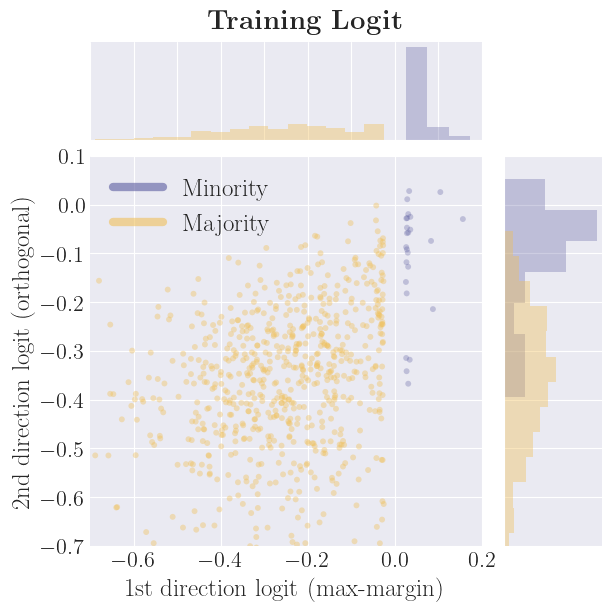

In [ ]:
plot_scatter_with_marginals_hist(
    logit1[0], logit2[0], y_imb,
    bins_x_minor=5, bins_y_minor=15,
    bins_x_major=15, bins_y_major=15,
    xlim=(-0.7, 0.2), ylim=(-0.7, 0.1),
    title='\\textbf{Training Logit}',
    save=True,
    path='llama3-8B_act_2Dtrain.pdf'
)